# Clustering

<br>

![clustering](https://scikit-learn.org/stable/_images/sphx_glr_plot_linkage_comparison_001.png)


## Definizione

Il clustering è una tecnica di machine learning non supervisonata, questo vuol dire che non esiste una variabile target su cui basare la bontà del modello.

In statistica, il clustering è un insieme di tecniche di analisi multivariata dei dati volte alla selezione e raggruppamento di elementi omogenei in un insieme di dati. Le tecniche di clustering si basano su misure relative alla somiglianza tra gli elementi. In molti approcci questa similarità, o meglio, dissimilarità, è concepita in termini di distanza in uno spazio multidimensionale. La bontà delle analisi ottenute dagli algoritmi di clustering dipende molto dalla scelta della metrica, e quindi da come è calcolata la distanza. Gli algoritmi di clustering raggruppano gli elementi sulla base della loro distanza reciproca, e quindi l'appartenenza o meno ad un insieme dipende da quanto l'elemento preso in esame è distante dall'insieme stesso. [fonte: [Wikipedia](https://it.wikipedia.org/wiki/Clustering)]

Per misurare la bontà del clustering esistono appositi indici che valutano l'omogeneità all'interno di un cluster e l'eterogeneità tra i gruppi. Con l'aiuto di queste tecniche siamo noi a decidere cosa i vari gruppi rappresentano.

I problemi più frequenti per cui viene utilizzato l'approccio non supervisionato, il clustering in particolare, sono:
* Determinare se i dati presentano relazioni significative nella forma dei concetti
* Valutare le prestazioni di un modello di apprendimento supervisionato
* Determinare l'insieme ideale degli attributi di input per l'apprendimento supervisionato
* Outlier detection

## Obiettivo del notebook

Il notebook ha come obiettivo quello di condurre una **customer segmentation** utilizzando diversi algoritmi di clustering, in particolare:
* K-Means
* Clustering Gerarchico
* DBSCAN


In [ ]:
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/Mall_Customers.csv

--2024-10-26 07:11:50--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/Mall_Customers.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 3.5.246.182, 52.95.143.30, 52.95.143.98, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|3.5.246.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3981 (3.9K) [text/csv]
Saving to: ‘Mall_Customers.csv.1’

Mall_Customers.csv. 100%[===================>]   3.89K  --.-KB/s    in 0s      

2024-10-26 07:11:50 (57.8 MB/s) - ‘Mall_Customers.csv.1’ saved [3981/3981]



In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import warnings

import os
warnings.filterwarnings("ignore")

In [2]:
# path = "Mall_Customers.csv"
path = "https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/Mall_Customers.csv"

### Dataset

Il dataset *Mall Customer* contiene i dati di 200 clienti di un centro commerciale, contiene:
* ID cliente
* sesso
* età
* reddito annuo
* indicatore di spesa (spending score) compreso tra 1-100.



In [3]:
df = pd.read_csv(path)
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


### Analisi Grafica

La prima cosa da fare è un'analisi grafica per avere un primo impatto del fenomeno.

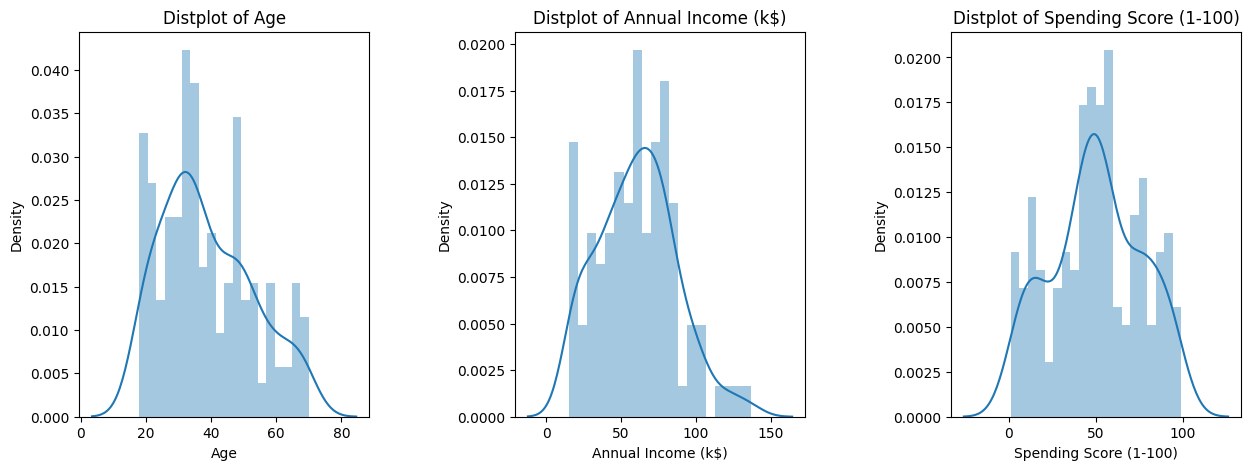

In [4]:
plt.figure(1 , figsize = (15 , 5))
n = 0
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

Dai grafici della distribuzione per *Reddito Annuo* e *Classi d'età* si evince che:
* La maggior parte delle persone ha un reddito tra 50K - 75K
* La fascia di reddito più bassa è intorno a 20K
* La fascia d'età più presente nell'ipermercato è intorno ai 35 anni
* I giovani frequentano più degli anziani
* L'indice di spesa è molto simmetrico intorno ai 50K
* Tutti i fenomeni possono essere approssimati da una distribuzione gaussiana

La distribuzione per genere mostra che i clienti sono quasi equidistribuiti per genere, con leggera prevalenza delle donne.

Infine il **Pairplot** ci mostra come il centro commerciale sia frequentato soprattutto da clienti con la fascia di reddito suddetta ma si rivolga anche a chi spende molto, soprattutto tra i più giovani.

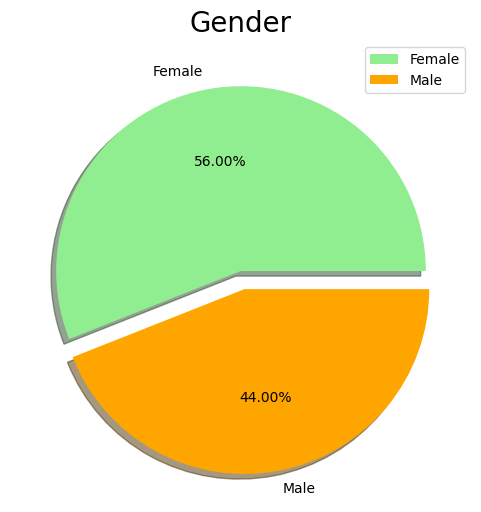

In [5]:
labels = ['Female', 'Male']
size = df['Gender'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, colors = colors, explode = explode,
        labels = labels, shadow = True, autopct = '%.2f%%'
        )
plt.title('Gender', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Pairplot for the Data')

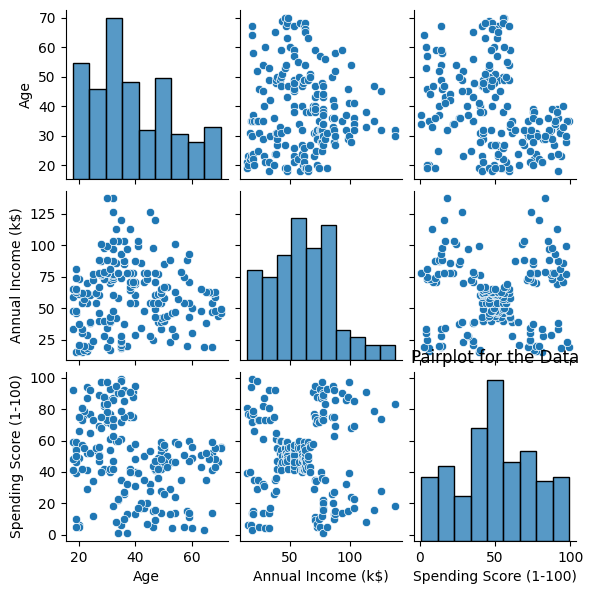

In [6]:
sns.pairplot(df.drop("CustomerID", axis=1), height=2)
plt.title('Pairplot for the Data')

### K-Means
L'algoritmo k-means (Lloyd, 1982) è una tecnica di clusterizzazione semplice ma efficace, è probabilmente la tecnica più utilizzata per fare clustering.
Vediamo i passi dell'algoritmo:
1. Scegliere il valore K, ovvero il numero totale di cluster da determinare
2. Scegliere in modo casuale K osservazioni nel dataset, saranno i primi centroidi dei nostri cluster. **Questa scelta casuale influenza il numero di passi chè l'algoritmo compie per convergere.**
3. Utilizzare una distanza (solitamente euclidea) per assegnare le restanti osservazioni al centroide più vicino
4. Utilizzare le osservazioni in ogni cluster per calcolare la media (il baricentro) dello stesso. Ogni baricentro sarà il nuovo centroide del cluster.
5. Se i nuovi centroidi sono identici ai precedenti il processo termina altrimenti si ripetono i punti da 3 a 5.

Come abbiamo visto il numero di cluster deve essere definito a priori, per farlo si può utilizzare il **metodo di Elbow**.

Questo metodo, non completamente robusto, anzi su Wikipedia è definito ambiguo, si basa sulla varianza spiegata, ovvero viene scelto il numero di cluster che dà l'incremento di varianza spiegata maggiore rispetto al precedente.

<br>

![elbow](https://upload.wikimedia.org/wikipedia/commons/c/cd/DataClustering_ElbowCriterion.JPG)


#### Scelta del numero dei cluster

Per scegliere il numero dei cluster utilizzeremo sempre il metodo di Elbow ma sull'inierzia. Questa è "il contrario" della varianza quindi và minimizzata.

In [7]:
from sklearn.cluster import KMeans

X = df[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].values

inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,
                        init='k-means++',
                        n_init = 10 ,
                        max_iter=300,
                        tol=0.0001,
                        random_state= 667  ,
                        algorithm='elkan'))
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

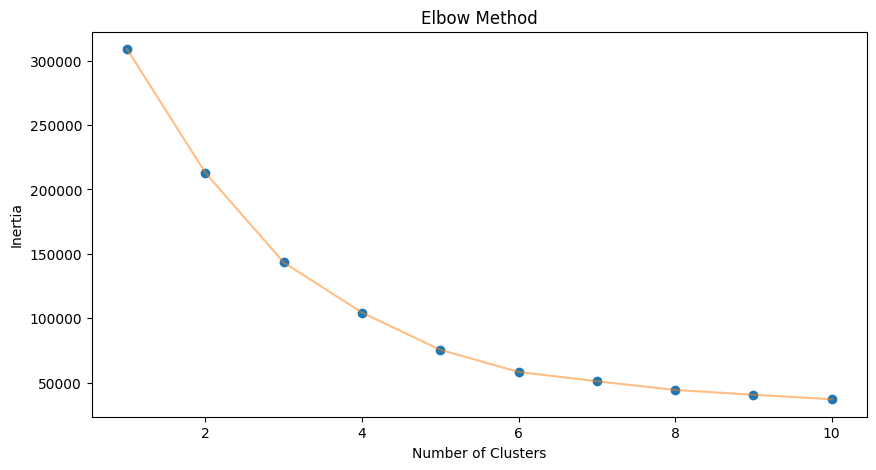

In [8]:
plt.figure(1 , figsize = (10 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

#### Applicazione dell'algoritmo

Di seguito impostiamo i parametri dell'algoritmo su Scikit-learn:
* n_clusters: il numero di cluster da creare
* init: il metodo di inizializzazione. *k-means++* seleziona i punti alla prima iterazione in modo da accelerare la convergenza dell'algoritmo
* max_iter: il numero di iterazioni prima che l'algortimo si fermi se non arrivasse a convergenza
* tol: la tolleranza per dichiarare la convergenza del K-Means e bloccare le iterazioni
* random_state: il seed per la replicabilità dei risultati
* algorithm: scegliamo *elkan* perchè è più performante con i dati densi

In [9]:
algorithm = KMeans(n_clusters = 6,
                   init='k-means++',
                   n_init = 10 ,
                   max_iter=300,
                   tol=0.0001,
                   random_state= 667,
                   algorithm='elkan')
algorithm.fit(X)
labels = algorithm.labels_
#centroids = algorithm.cluster_centers_

#### Grafico dei risultati

In [10]:
df['label'] =  labels
trace1 = go.Scatter3d(
                        x= df['Age'],
                        y= df['Spending Score (1-100)'],
                        z= df['Annual Income (k$)'],
                        mode='markers',
                        marker=dict(
                            color = df['label'],
                            size= 20,
                            line=dict(
                                color= df['label'],
                                width= 12
                            ),
                            opacity=0.8)
                        )
data = [trace1]
layout = go.Layout(
                    title= 'Clusters',
                    scene = dict(
                            xaxis = dict(title  = 'Age'),
                            yaxis = dict(title  = 'Spending Score'),
                            zaxis = dict(title  = 'Annual Income')
                        )
                )
fig = go.Figure(data=data, layout=layout)
fig.show(render="notebook")

### Clustering Gerarchico

Il clustering gerarchico è un approccio di clustering che mira a costruire una gerarchia di cluster. Le strategie per il clustering gerarchico sono tipicamente di due tipi:
* **Agglomerativo**: alla prima iterazione ogni osservazione è un cluster e ad ogni passo vengono aggregati in gruppi sempre più numerosi secondo una distanza
* **Divisivo**: si parte da un solo cluster e si suddividono le osservazioni ad ogni iterazione

Per decidere quali cluster devono essere combinati è necessario definire una misura di similarità (o dissimilarità) tra cluster. Nella maggior parte dei metodi di clustering gerarchico si fa uso di metriche specifiche che quantificano la distanza tra coppie di elementi.

A differenza del K-Means non ci serve un numero di cluster definito a priori.

<br>

![HClus](https://new.pharmacelera.com/wp-content/uploads/2019/08/clusters-1024x530.png)


#### Applicazione dell'algoritmo

Impostiamo l'algoritmo su Scikit-learn, useremo il metodo *agglomerativo*:
* n_clusters: il numero di cluster. Può essere non definito ma bisogna dare la metrica di similarità.
* distance_threshold: la metrica. Imposteremo a 0, quindi *full_tree*


In [11]:
from sklearn.cluster import AgglomerativeClustering

AggC = AgglomerativeClustering(n_clusters = None, distance_threshold=0)
AggC.fit(X)

labels = AggC.labels_

#### Grafico dei risultati

Per vedere i risultati del clustering gerarchico il grafico è il dendrogramma.

Nell'[esempio ufficiale di scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py) troviamo una funzione per costruire un buon dendrogramma.

In [12]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Vediamo che scendendo a 4 livelli vengono formati tre cluster distinti.

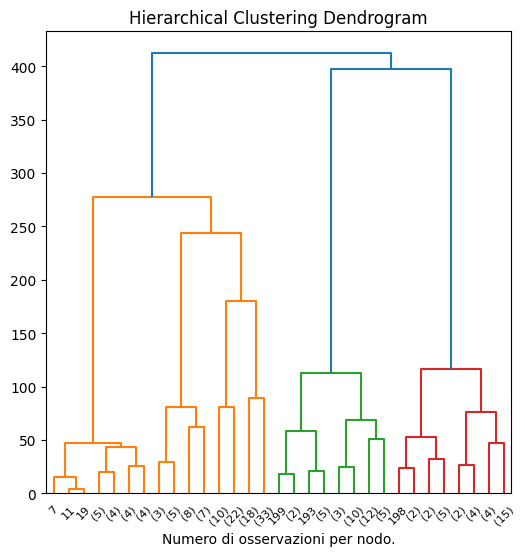

In [13]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(AggC, truncate_mode='level', p=4)
plt.xlabel("Numero di osservazioni per nodo.")
plt.show()

### DBSCAN

<br>

![DBSCAN](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/400px-DBSCAN-Illustration.svg.png)

Il **DBSCAN** è un lagoritmo basato sulla densità e connette regioni di punti con densità sufficientemente alta.

Necessita di due parametri: ε (eps) e del numero minimo di punti richiesti per formare un cluster (minPts). Si comincia con un punto casuale che non è stato ancora visitato. Viene calcolato il suo ε-vicinato e se contiene un numero sufficiente di punti viene creato un nuovo cluster. Se ciò non avviene il punto viene etichettato come rumore e successivamente potrebbe essere ritrovato in un ε-vicinato sufficientemente grande riconducibile ad un punto differente entrando a far parte di un cluster.

Se un punto è associato ad un cluster anche i punti del suo ε-vicinato sono parte del cluster. Conseguentemente tutti i punti trovati all'interno del suo ε-vicinato sono aggiunti al cluster, così come i loro ε-vicinati. Questo processo continua fino a quando il cluster viene completato. Il processo continua fino a quando non sono stati visitati tutti i punti.

Vantaggi:
* non richiede di conoscere il numero di cluster a priori
* può trovare cluster di forme arbitrarie.
* possiede la nozione di rumore
* richiede soltanto due parametri ed è per lo più insensibile all'ordine dei punti nel database

Svantaggi:
* La qualità del clustering generato da DBSCAN dipende dalla sua misura della distanza. ***Maledizione della dimensionalità***
* Non è in grado di classificare insiemi di dati con grandi differenze nelle densità (dati sparsi)

[Fonte: DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)

#### Applicazione dell'algoritmo

Impostiamo l'algoritmo su Scikit-learn:
* eps: la massima distanza tra due campioni per essere considerati vicini
* min_samples: il numero minimo di osservazioni per essere considerato un cluster core
* algorithm: algoritmo usato dal KNN per formare i cluster

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=0.5, min_samples = 10, algorithm = "ball_tree")
dbscan.fit(X_scaled)
labels = dbscan.labels_

# si usa questo metodo perchè i -1 sono "noise" data
print("Il numero di cluster è pari a: ", len(set(labels)) - (1 if -1 in labels else 0))

Il numero di cluster è pari a:  4


#### Grafico dei risultati

In [15]:
df['label'] =  labels
trace1 = go.Scatter3d(
    x= df['Age'],
    y= df['Spending Score (1-100)'],
    z= df['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = df['label'],
        size= 20,
        line=dict(
            color= df['label'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
fig.show(render="notebook")